In [1]:
import io
import bson
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.data import imread
import multiprocessing as mp
import pandas as pd
import tensorflow as tf
import numpy as np
from time import time

In [2]:
from keras.preprocessing.image import load_img, img_to_array, Iterator, ImageDataGenerator
from keras import backend as K

Using TensorFlow backend.


In [3]:
#LOADING THE EXAMPLE DATA SET

data = bson.decode_file_iter(open('train_example.bson', 'rb'))
ids = []
pics = []
prod_to_category = dict()

for c, d in enumerate(data):
    product_id = d['_id']
    category_id = d['category_id'] # This won't be in Test data
    prod_to_category[product_id] = category_id
    for e, pic in enumerate(d['imgs']):
        ids.append(d['category_id'])
        pics.append(imread(io.BytesIO(pic['picture'])))
        picture = imread(io.BytesIO(pic['picture']))
        # do something with the picture, etc

prod_to_category = pd.DataFrame.from_dict(prod_to_category, orient='index')
prod_to_category.index.name = '_id'
prod_to_category.rename(columns={0: 'category_id'}, inplace=True)

ids = np.asarray(ids)

nppics = np.asarray(pics)

In [ ]:
enc = OneHotEncoder()
onehot_ids = enc.fit_transform(ids.reshape(-1, 1))

In [4]:
#LOAD THE REAL DATA WITH KERAS
# I DON'T REALLY KNOW HOW THIS WORKS, BUT IT DOES

def make_category_tables():
    cat2idx = {}
    idx2cat = {}
    for ir in categories_df.itertuples():
        category_id = ir[0]
        category_idx = ir[4]
        cat2idx[category_id] = category_idx
        idx2cat[category_idx] = category_id
    return cat2idx, idx2cat

class BSONIterator(Iterator):
    def __init__(self, bson_file, images_df, offsets_df, num_class,
                 image_data_generator, target_size=(180, 180), with_labels=True,
                 batch_size=32, shuffle=False, seed=None):

        self.file = bson_file
        self.images_df = images_df
        self.offsets_df = offsets_df
        self.with_labels = with_labels
        self.samples = len(images_df)
        self.num_class = num_class
        self.image_data_generator = image_data_generator
        self.target_size = tuple(target_size)
        self.image_shape = self.target_size + (3,)

        print("Found %d images belonging to %d classes." % (self.samples, self.num_class))

        super(BSONIterator, self).__init__(self.samples, batch_size, shuffle, seed)

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=K.floatx())
        if self.with_labels:
            batch_y = np.zeros((len(batch_x), self.num_class), dtype=K.floatx())
            #batch_y = np.zeros((len(batch_x), 49), dtype=K.floatx())

            #batch_y = np.zeros(len(batch_x), dtype=K.floatx())

        for i, j in enumerate(index_array):
            # Protect file and dataframe access with a lock.
            with self.lock:
                image_row = self.images_df.iloc[j]
                product_id = image_row["product_id"]
                offset_row = self.offsets_df.loc[product_id]

                # Read this product's data from the BSON file.
                self.file.seek(offset_row["offset"])
                item_data = self.file.read(offset_row["length"])

            # Grab the image from the product.
            item = bson.BSON.decode(item_data)
            img_idx = image_row["img_idx"]
            bson_img = item["imgs"][img_idx]["picture"]

            # Preprocess the image.
            img = load_img(io.BytesIO(bson_img), target_size=self.target_size)
            x = img_to_array(img)
            x = self.image_data_generator.random_transform(x)
            x = self.image_data_generator.standardize(x)

            # Add the image and the label to the batch (one-hot encoded).
            batch_x[i] = x
            if self.with_labels:
                #cat1_idx = le.transform(nt.loc[image_row["category_idx"]]['category_level1'])
                #batch_y[i, cat1_idx] = 1
                batch_y[i, image_row["category_idx"]] = 1
                #batch_y[i] = image_row["category_idx"]

        if self.with_labels:
            return batch_x, batch_y
        else:
            return batch_x

    def next(self):
        with self.lock:
            index_array = next(self.index_generator)
        return self._get_batches_of_transformed_samples(index_array)

train_bson_path = "train.bson"


    
categories_df = pd.read_csv("categories.csv", index_col=0)
cat2idx, idx2cat = make_category_tables()

train_offsets_df = pd.read_csv("train_offsets.csv", index_col=0)
train_images_df = pd.read_csv("train_images.csv", index_col=0)
val_images_df = pd.read_csv("val_images.csv", index_col=0)

train_bson_file = open(train_bson_path, "rb")

num_classes = 5270
num_train_images = len(train_images_df)
num_val_images = len(val_images_df)
batch_size = 128

# Tip: use ImageDataGenerator for data augmentation and preprocessing.
train_datagen = ImageDataGenerator()
train_gen = BSONIterator(train_bson_file, train_images_df, train_offsets_df, 
                         num_classes, train_datagen, batch_size=batch_size, shuffle=True)

val_datagen = ImageDataGenerator()
val_gen = BSONIterator(train_bson_file, val_images_df, train_offsets_df,
                       num_classes, val_datagen, batch_size=batch_size)

Found 9898873 images belonging to 5270 classes.
Found 2472420 images belonging to 5270 classes.


In [5]:
%time bx, by = next(train_gen)

CPU times: user 1.45 s, sys: 236 ms, total: 1.69 s
Wall time: 1.74 s


In [ ]:
running_tot = np.zeros(5270, )

In [15]:
bx.shape

(128, 180, 180, 3)

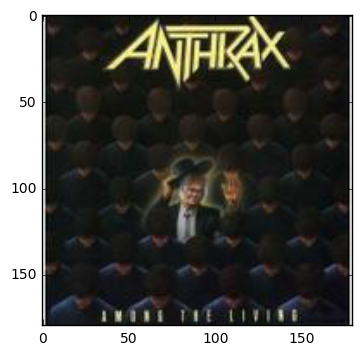

In [72]:
plt.imshow(bx[14, :, :, :]/255)

In [47]:
bx[15, :]

array([[[ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        ..., 
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.]],

       [[ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        ..., 
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.]],

       [[ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        ..., 
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.]],

       ..., 
       [[ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        ..., 
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.]],

       [[ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        ..., 
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 

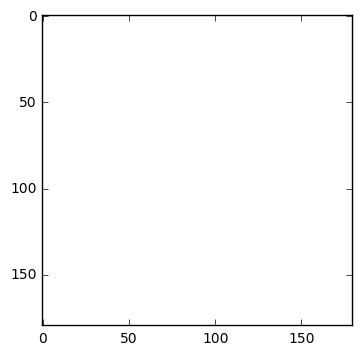

In [67]:
plt.imshow(np.zeros((180, 180, 3)) + 1)

In [15]:
train_gen = BSONIterator(train_bson_file, train_images_df, train_offsets_df, 
                         num_classes, train_datagen, batch_size=512, shuffle=True)

Found 9898873 images belonging to 5270 classes.


In [ ]:
running_tot += np.sum(by, 0)

In [8]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_4x4(x):
    return tf.nn.max_pool(x, ksize=[1, 4, 4, 1],
                        strides=[1, 4, 4, 1], padding='SAME')

def max_pool_3x3(x):
    return tf.nn.max_pool(x, ksize=[1, 3, 3, 1],
                        strides=[1, 3, 3, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [22]:
n_cats = 5270

#set up placeholders
x = tf.placeholder(tf.float32, shape=[None, 180, 180, 3], name='input_images')
y_ = tf.placeholder(tf.float32, shape=[None, n_cats], name='one_hotted_labels')

#set up neurons for 1st convolutional layer
W_conv1 = weight_variable([4, 4, 3, 8])
b_conv1 = bias_variable([8])

#don't know why this step is necessary, but it is
x_image = tf.reshape(x, [-1,180,180,3])

#do the first convolutional layer, pooling
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_3x3(h_conv1)

#do the second convolutional layer, pooling
W_conv2 = weight_variable([4, 4, 8, 8]) #4x4 templates, 32 input channels, 64 output channels
b_conv2 = bias_variable([8])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

#do the second convolutional layer, pooling
W_conv3 = weight_variable([4, 4, 8, 8]) #4x4 templates, 32 input channels, 64 output channels
b_conv3 = bias_variable([8])

h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_3x3(h_conv3)

h_pool3_flat = tf.reshape(h_pool3, [-1, 10*10*8])

#Densely connected layer
W_fc1 = weight_variable([10*10*8, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

#Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#readout layer
W = weight_variable([1024, n_cats])
b = bias_variable([n_cats])

y_conv = tf.matmul(h_fc1_drop, W) + b

sess = tf.InteractiveSession()

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))


train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1, name='argmax_prediction'), tf.argmax(y_,1, name='argmax_actual_val'))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())

running_tot = np.zeros(5270, )
#Do the training
for i in range(15000):
    bx, by = next(train_gen)
    
    running_tot += np.sum(by, 0)
    
    if i%100 == 0:
        #print(i)
        init_acc = accuracy.eval(feed_dict={x: bx, y_: by, keep_prob: 1.0})
        starttime = time()


    
    %time train_step.run(feed_dict={x: bx, y_: by, keep_prob: 0.5})
    
    if i%100 == 0:
        #print('After training on those samples:')
        elapsed = time() - starttime
        aft_acc = accuracy.eval(feed_dict={x: bx, y_: by, keep_prob: 1.0})
        print("after {} cycles, input batch went from {} correct to {:.2f}, took {:.2f} seconds".format(i, init_acc*128, aft_acc*128, elapsed))
        print("Median; mean number of images for each category is {}; {}".format(np.median(running_tot), np.mean(running_tot)))
        
print("Saving model...")
saver = tf.train.Saver()
save_path = saver.save(sess, "saved_trained_model.ckpt")

CPU times: user 22.6 s, sys: 6.48 s, total: 29.1 s
Wall time: 8.2 s
after 0 cycles, input batch went from 0.0 correct to 0.00, took 8.20 seconds
Median; mean number of images for each category is 0.0; 0.09715370018975332
CPU times: user 22.3 s, sys: 6.33 s, total: 28.6 s
Wall time: 7.11 s
CPU times: user 22.8 s, sys: 6.74 s, total: 29.5 s
Wall time: 7.3 s
CPU times: user 22.2 s, sys: 6.64 s, total: 28.9 s
Wall time: 7.16 s
CPU times: user 22.3 s, sys: 6.54 s, total: 28.9 s
Wall time: 7.21 s
CPU times: user 21.9 s, sys: 6.39 s, total: 28.3 s
Wall time: 7 s
CPU times: user 22.9 s, sys: 6.36 s, total: 29.3 s
Wall time: 7.09 s
CPU times: user 22.2 s, sys: 6.01 s, total: 28.2 s
Wall time: 6.82 s
CPU times: user 21.8 s, sys: 6.17 s, total: 27.9 s
Wall time: 6.89 s
CPU times: user 21.8 s, sys: 5.89 s, total: 27.7 s
Wall time: 6.78 s
CPU times: user 21.7 s, sys: 6.22 s, total: 27.9 s
Wall time: 7.31 s
CPU times: user 21.5 s, sys: 5.95 s, total: 27.4 s
Wall time: 6.95 s
CPU times: user 21.8 s, 

KeyboardInterrupt: 

In [ ]:
vx, vy = next(val_gen)

In [ ]:
saver = tf.train.Saver()

In [ ]:
save_path = saver.save(sess, "trained_model_1.ckpt")

In [ ]:
acc = []
for k in range(100):
    vx, vy = next(val_gen)
    acc.append(accuracy.eval(feed_dict={x: vx, y_: vy, keep_prob: 1.0}))

In [ ]:
accuracy.eval(feed_dict={x: vx, y_: vy})

In [ ]:
np.mean(acc)

In [ ]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(32, 3, padding="same", activation="relu", input_shape=(180, 180, 3)))
#model.add(MaxPooling2D())
#model.add(Conv2D(64, 3, padding="same", activation="relu"))
#model.add(MaxPooling2D())
#model.add(Conv2D(128, 3, padding="same", activation="relu"))
#model.add(MaxPooling2D())
#model.add(GlobalAveragePooling2D())
#model.add(Dense(num_classes, activation="softmax"))

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

In [ ]:
15*15*64

In [ ]:
model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(180, 180, 3)))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
tf.__version__

In [ ]:
import tensorflow as tf

In [ ]:
nt = pd.read_csv('categories.csv', index_col='category_idx')

In [ ]:
total_parameters = 0
for variable in tf.trainable_variables():
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
    print(shape)
    print(len(shape))
    variable_parameters = 1
    for dim in shape:
        print(dim)
        variable_parameters *= dim.value
    print(variable_parameters)
    total_parameters += variable_parameters
print(total_parameters)

In [ ]:
nt.loc[[1000003400, 1000003404]]

In [ ]:
nt['category_level1'].unique()

In [ ]:
ohe = OneHotEncoder()
le = LabelEncoder()

In [ ]:
le.fit(nt['category_level1'].unique())

In [ ]:
ohe.fit(range(49))

In [ ]:
ohe.fit(le.transform(nt['category_level1'].unique()))

In [ ]:
%time ohe.fit_transform(le.transform(nt['category_level1']).reshape(1, -1))

In [ ]:
vs = nt['category_level1'][:100]

In [ ]:
vs_ls = le.transform(vs)

In [ ]:
ohe = np.zeros((100, 49))

In [ ]:
for i in range(100):
    ohe[i, vs_ls[i]] = 1

In [ ]:
ohe.shape

In [ ]:
categories